### Perform 1st and 2nd Order LASSO on rates and data from model 0

In [29]:
import os, sys
import time
import csv
import tqdm.notebook as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.decomposition import PCA
import warnings
from sklearn.exceptions import ConvergenceWarning

from mgsa.io import samples_from_soils, get_function, get_data
from mgsa.modeling import Model
from mgsa.helpers import plot

### First load in X (variants) and Y (targets) for CHL +/-

In [30]:
NARG_INFO = {
    "KO": "K00370",
    "ORF_GROUPS_FPATH": "../out/groups/assignments_K00370_v1.tsv"
}

NIRB_INFO = {
    "KO": "K00362",
    "ORF_GROUPS_FPATH": "../out/groups/assignments_K00362_v1.tsv"
}

NATIVE_IDXS = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
NATIVE_PHS = np.array([5.0, 5.3, 5.41, 5.8, 6.15, 6.3, 6.5, 6.75, 6.9,  7.1])
PERTURBED_PHS = np.linspace(3.8, 8.4, 11)

OUTDIR = "../out/model_regression/nar"
IMGDIR = f"{OUTDIR}/images"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(IMGDIR, exist_ok=True)

def texify(param_name):
    return {
        "gamma_A": "\\gamma_{{A}}", 
        "gamma_I": "\\gamma_{{I}}", 
        "r_A": "r_{{A}}", 
        "r_I1": "r_{{I1}}", 
        "r_I2": "r_{{I2}}", 
        "K_A": "K_{{A}}", 
        "K_I": "K_{{I}}", 
        "mu": "\\mu", 
    }[param_name]

t_data_drug = np.linspace(0, 19, 20)

soils = [
    'Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 
    'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17'
]



def load_orf_groups(fpath) -> tuple[dict[int:str], np.ndarray[int]]:
    groups = {}
    idxs = []
    with open(fpath, "r") as f:
        csvreader = csv.reader(f, delimiter=" ")
        for row in csvreader:  # process each row
            orf = row[0]
            gidx = int(row[1])
            if gidx in groups:
                groups[gidx].append(orf)
            else:
                groups[gidx] = [orf]
                idxs.append(gidx)
    return groups, np.sort(idxs)

##############################################################################
##  Collect narG data

# Load ORF groups for narG
groups, group_idxs = load_orf_groups(NARG_INFO["ORF_GROUPS_FPATH"])
total = 0
for gidx in group_idxs:
    group = groups[gidx]
    n = len(group)
    print(f"Group {gidx}: {n} ORFs")
    total += n
print(f"  Total: {total}")

# Aggregate T0 and T9 expression data in the CHL+ and CHL- conditions
gidx2exp_chl_pos_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_pos_t9 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t9 = {gidx: [] for gidx in group_idxs}
for gidx in group_idxs:
    group = groups[gidx]
    for i, orf in enumerate(group):
        data_chl_pos_t0, data_chl_pos_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NARG_INFO["KO"], 
            drug='CHL', 
            map='09',
        )
        data_chl_neg_t0, data_chl_neg_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NARG_INFO["KO"], 
            drug='None', 
            map='09',
        )
        # Subset T0 samples to those of interest
        data_chl_pos_t0 = data_chl_pos_t0[NATIVE_IDXS]
        data_chl_neg_t0 = data_chl_neg_t0[NATIVE_IDXS]

        gidx2exp_chl_pos_t0[gidx].append(data_chl_pos_t0)
        gidx2exp_chl_pos_t9[gidx].append(data_chl_pos_t9)
        gidx2exp_chl_neg_t0[gidx].append(data_chl_neg_t0)
        gidx2exp_chl_neg_t9[gidx].append(data_chl_neg_t9)

    # Sum the expression data in each group
    gidx2exp_chl_pos_t0[gidx] = np.sum(gidx2exp_chl_pos_t0[gidx], axis=0)
    gidx2exp_chl_pos_t9[gidx] = np.sum(gidx2exp_chl_pos_t9[gidx], axis=0)
    gidx2exp_chl_neg_t0[gidx] = np.sum(gidx2exp_chl_neg_t0[gidx], axis=0)
    gidx2exp_chl_neg_t9[gidx] = np.sum(gidx2exp_chl_neg_t9[gidx], axis=0)

# Check lengths are correct
for gidx in group_idxs:
    assert gidx2exp_chl_pos_t0[gidx].shape == (10,), "Wrong shape for t0 pos"
    assert gidx2exp_chl_pos_t9[gidx].shape == (10,11), "Wrong shape for t9 pos"
    assert gidx2exp_chl_neg_t0[gidx].shape == (10,), "Wrong shape for t0 neg"
    assert gidx2exp_chl_neg_t9[gidx].shape == (10,11), "Wrong shape for t9 neg"

# Construct arrays of aggregated soil expression levels. The last axis 
# corresponds to the groups.
nar_exp_chl_pos_t0 = np.zeros([10, len(group_idxs)])
nar_exp_chl_pos_t9 = np.zeros([10, 11, len(group_idxs)])
nar_exp_chl_neg_t0 = np.zeros([10, len(group_idxs)])
nar_exp_chl_neg_t9 = np.zeros([10, 11, len(group_idxs)])
for i, gidx in enumerate(group_idxs):
    nar_exp_chl_pos_t0[...,i] = gidx2exp_chl_pos_t0[gidx]
    nar_exp_chl_pos_t9[...,i] = gidx2exp_chl_pos_t9[gidx]
    nar_exp_chl_neg_t0[...,i] = gidx2exp_chl_neg_t0[gidx]
    nar_exp_chl_neg_t9[...,i] = gidx2exp_chl_neg_t9[gidx]

##############################################################################
##  Collect nirB data

# Load ORF groups for nirB
groups, group_idxs = load_orf_groups(NIRB_INFO["ORF_GROUPS_FPATH"])
total = 0
for gidx in group_idxs:
    group = groups[gidx]
    n = len(group)
    print(f"Group {gidx}: {n} ORFs")
    total += n
print(f"  Total: {total}")

# Aggregate T0 and T9 expression data in the CHL+ and CHL- conditions
gidx2exp_chl_pos_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_pos_t9 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t9 = {gidx: [] for gidx in group_idxs}
for gidx in group_idxs:
    group = groups[gidx]
    for i, orf in enumerate(group):
        data_chl_pos_t0, data_chl_pos_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NIRB_INFO["KO"], 
            drug='CHL', 
            map='09',
        )
        data_chl_neg_t0, data_chl_neg_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NIRB_INFO["KO"], 
            drug='None', 
            map='09',
        )
        # Subset T0 samples to those of interest
        data_chl_pos_t0 = data_chl_pos_t0[NATIVE_IDXS]
        data_chl_neg_t0 = data_chl_neg_t0[NATIVE_IDXS]

        gidx2exp_chl_pos_t0[gidx].append(data_chl_pos_t0)
        gidx2exp_chl_pos_t9[gidx].append(data_chl_pos_t9)
        gidx2exp_chl_neg_t0[gidx].append(data_chl_neg_t0)
        gidx2exp_chl_neg_t9[gidx].append(data_chl_neg_t9)

    # Sum the expression data in each group
    gidx2exp_chl_pos_t0[gidx] = np.sum(gidx2exp_chl_pos_t0[gidx], axis=0)
    gidx2exp_chl_pos_t9[gidx] = np.sum(gidx2exp_chl_pos_t9[gidx], axis=0)
    gidx2exp_chl_neg_t0[gidx] = np.sum(gidx2exp_chl_neg_t0[gidx], axis=0)
    gidx2exp_chl_neg_t9[gidx] = np.sum(gidx2exp_chl_neg_t9[gidx], axis=0)

# Check lengths are correct
for gidx in group_idxs:
    assert gidx2exp_chl_pos_t0[gidx].shape == (10,), "Wrong shape for t0 pos"
    assert gidx2exp_chl_pos_t9[gidx].shape == (10,11), "Wrong shape for t9 pos"
    assert gidx2exp_chl_neg_t0[gidx].shape == (10,), "Wrong shape for t0 neg"
    assert gidx2exp_chl_neg_t9[gidx].shape == (10,11), "Wrong shape for t9 neg"

# Construct arrays of aggregated soil expression levels. The last axis 
# corresponds to the groups.
nir_exp_chl_pos_t0 = np.zeros([10, len(group_idxs)])
nir_exp_chl_pos_t9 = np.zeros([10, 11, len(group_idxs)])
nir_exp_chl_neg_t0 = np.zeros([10, len(group_idxs)])
nir_exp_chl_neg_t9 = np.zeros([10, 11, len(group_idxs)])
for i, gidx in enumerate(group_idxs):
    nir_exp_chl_pos_t0[...,i] = gidx2exp_chl_pos_t0[gidx]
    nir_exp_chl_pos_t9[...,i] = gidx2exp_chl_pos_t9[gidx]
    nir_exp_chl_neg_t0[...,i] = gidx2exp_chl_neg_t0[gidx]
    nir_exp_chl_neg_t9[...,i] = gidx2exp_chl_neg_t9[gidx]


Group 1: 18 ORFs
Group 2: 4 ORFs
Group 3: 14 ORFs
Group 4: 21 ORFs
  Total: 57
Group 1: 24 ORFs
Group 2: 15 ORFs
Group 3: 10 ORFs
Group 4: 13 ORFs
  Total: 62


In [31]:
##############################################################################
##  Normalize narG expression levels
nar_rel_exp_chl_pos_t0 = nar_exp_chl_pos_t0 / np.sum(nar_exp_chl_pos_t0, -1)[...,None]
nar_rel_exp_chl_pos_t0 = nar_rel_exp_chl_pos_t0[:, np.newaxis, :]
nar_rel_exp_chl_pos_t0 = np.broadcast_to(nar_rel_exp_chl_pos_t0, (10, 11, 4))

##############################################################################
##  Normalize nirB expression levels
nir_rel_exp_chl_pos_t0 = nir_exp_chl_pos_t0 / np.sum(nir_exp_chl_pos_t0, -1)[...,None]
nir_rel_exp_chl_pos_t0 = nir_rel_exp_chl_pos_t0[:, np.newaxis, :]
nir_rel_exp_chl_pos_t0 = np.broadcast_to(nir_rel_exp_chl_pos_t0, (10, 11, 4))

##############################################################################
##  Normalize narG expression levels

nar_rel_exp_chl_pos_t9 = nar_exp_chl_pos_t9 / np.sum(nar_exp_chl_pos_t9, -1)[...,None]

##############################################################################
##  Normalize nirB expression levels
nir_rel_exp_chl_pos_t9 = nir_exp_chl_pos_t9 / np.sum(nir_exp_chl_pos_t9, -1)[...,None]

##############################################################################
##  Normalize narG expression levels
nar_rel_exp_chl_neg_t0 = nar_exp_chl_neg_t0 / np.sum(nar_exp_chl_neg_t0, -1)[...,None]
nar_rel_exp_chl_neg_t0 = nar_rel_exp_chl_neg_t0[:, np.newaxis, :]
nar_rel_exp_chl_neg_t0 = np.broadcast_to(nar_rel_exp_chl_neg_t0, (10, 11, 4))

##############################################################################
##  Normalize nirB expression levels
nir_rel_exp_chl_neg_t0 = nir_exp_chl_neg_t0 / np.sum(nir_exp_chl_neg_t0, -1)[...,None]
nir_rel_exp_chl_neg_t0 = nir_rel_exp_chl_neg_t0[:, np.newaxis, :]
nir_rel_exp_chl_neg_t0 = np.broadcast_to(nir_rel_exp_chl_neg_t0, (10, 11, 4))

##############################################################################
##  Normalize narG expression levels

nar_rel_exp_chl_neg_t9 = nar_exp_chl_neg_t9 / np.sum(nar_exp_chl_neg_t9, -1)[...,None]

##############################################################################
##  Normalize nirB expression levels
nir_rel_exp_chl_neg_t9 = nir_exp_chl_neg_t9 / np.sum(nir_exp_chl_neg_t9, -1)[...,None]

X_NAR_CHL_POS = np.concatenate([nar_rel_exp_chl_pos_t0, nar_rel_exp_chl_pos_t9], axis = -1)
X_NIR_CHL_POS = np.concatenate([nir_rel_exp_chl_pos_t0, nir_rel_exp_chl_pos_t9], axis = -1)
X_NAR_CHL_NEG = np.concatenate([nar_rel_exp_chl_neg_t0, nar_rel_exp_chl_neg_t9], axis = -1)
X_NIR_CHL_NEG = np.concatenate([nir_rel_exp_chl_neg_t0, nir_rel_exp_chl_neg_t9], axis = -1)

### Collect Metabolic Parameters (Target for Regression)

In [32]:
rA_chl_pos = pd.read_csv('../out/metabolic_parameters/rA_model0_chl_pos.tsv', sep = '\t', header = None).values
rI_chl_pos = pd.read_csv('../out/metabolic_parameters/rI_model0_chl_pos.tsv', sep = '\t', header = None).values
rA_chl_neg = pd.read_csv('../out/metabolic_parameters/rA_model0_chl_neg.tsv', sep = '\t', header = None).values
rI_chl_neg = pd.read_csv('../out/metabolic_parameters/rI_model0_chl_neg.tsv', sep = '\t', header = None).values

Y_CHL_POS = np.concatenate([rA_chl_pos[..., np.newaxis], rI_chl_pos[..., np.newaxis]], axis = -1)
Y_CHL_NEG = np.concatenate([rA_chl_neg[..., np.newaxis], rI_chl_neg[..., np.newaxis]], axis = -1)

### Perform 1st order LASSO on CHL+ data

And do that per column (fixed pH sets)

In [33]:
##############################################################################
### Lasso for NAR, NIR CHL+ case

ALPHA = 0.01  # Regularization strength

clf_nar = []
clf_nir = []
for i in range(11):
    clf = linear_model.Lasso(alpha=ALPHA)
    clf.fit(X_NAR_CHL_POS[:,i,:], Y_CHL_POS[:,i,0])
    clf_nar.append(clf)
    clf = linear_model.Lasso(alpha=ALPHA)
    clf.fit(X_NIR_CHL_POS[:,i,:], Y_CHL_POS[:,i,1])
    clf_nir.append(clf)

print("--------------------------------------------------")
print("NAR")
for i in range(11):
    print(f"Coefficients {clf_nar[i].coef_.shape}:\n", clf_nar[i].coef_)
    print(f"Intercepts: {clf_nar[i].intercept_.shape}\n", clf_nar[i].intercept_)
print("--------------------------------------------------")

print("--------------------------------------------------")
print("NIR")
for i in range(11):
    print(f"Coefficients {clf_nir[i].coef_.shape}:\n", clf_nir[i].coef_)
    print(f"Intercepts: {clf_nir[i].intercept_.shape}\n", clf_nir[i].intercept_)
print("--------------------------------------------------")


--------------------------------------------------
NAR
Coefficients (8,):
 [-0.27560443 -0.          0.          0.8778347   5.03626632 -0.
  0.         -0.        ]
Intercepts: ()
 -1.4559517970236842
Coefficients (8,):
 [ 0.         -0.          0.43549029 -7.82013148 -0.         -0.
 -0.          7.33660281]
Intercepts: ()
 0.9847265980501613
Coefficients (8,):
 [ 0.32439904 -0.          0.         -0.47872748  1.66784282 -0.
 -0.         -0.        ]
Intercepts: ()
 -0.2453993990685438
Coefficients (8,):
 [ 0.23567236  0.         -0.         -0.          1.71866852 -0.
 -0.         -0.        ]
Intercepts: ()
 -0.49481685099275596
Coefficients (8,):
 [ 0.14849371 -0.         -0.         -0.          0.28617211  0.
 -0.         -0.80654047]
Intercepts: ()
 0.5050743755291643
Coefficients (8,):
 [ 0.         -0.          0.         -0.33065139  0.          0.
 -0.         -0.        ]
Intercepts: ()
 0.5262324201957334
Coefficients (8,):
 [-0. -0.  0. -0.  0.  0. -0. -0.]
Intercepts:

### Collect LASSO-predicted rate parameters

In [34]:
rA_grid = np.zeros((10,11))
rI_grid = np.zeros((10,11))
X_NIR_T0 = nir_rel_exp_chl_pos_t0
X_NAR_T0 = nar_rel_exp_chl_pos_t0
X_NIR_T9 = nir_rel_exp_chl_pos_t9
X_NAR_T9 = nar_rel_exp_chl_pos_t9
for native in tqdm.trange(10, desc="native", leave=False):
        for pert in tqdm.trange(11, desc="perturbed", leave=False):
            rA_pred = 0
            rI_pred = 0
            for i in range(len(group_idxs)):
                rA_pred += X_NAR_T0[native, pert, i]*clf_nar[pert].coef_[i]
                rI_pred += X_NIR_T0[native, pert, i]*clf_nir[pert].coef_[i]  
                rA_pred += X_NAR_T9[native, pert, i]*clf_nar[pert].coef_[i + len(group_idxs)]
                rI_pred += X_NIR_T9[native, pert, i]*clf_nir[pert].coef_[i + len(group_idxs)]  
            rA_pred += clf_nar[pert].intercept_
            rI_pred += clf_nir[pert].intercept_
            y_pred = [rA_pred, rI_pred]
            rA_grid[native, pert] = rA_pred
            rI_grid[native, pert] = rI_pred


native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

### Make a plot comparing predicted to fitted rA and rI

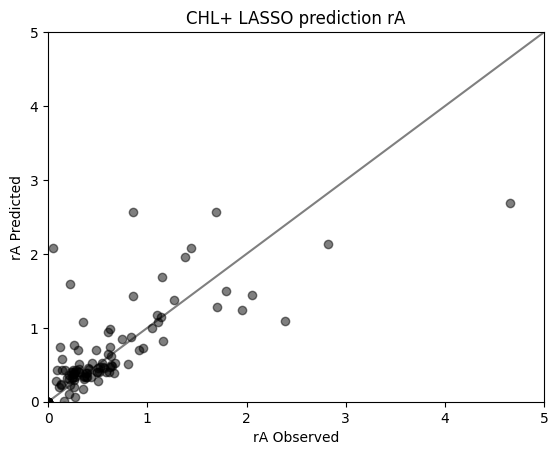

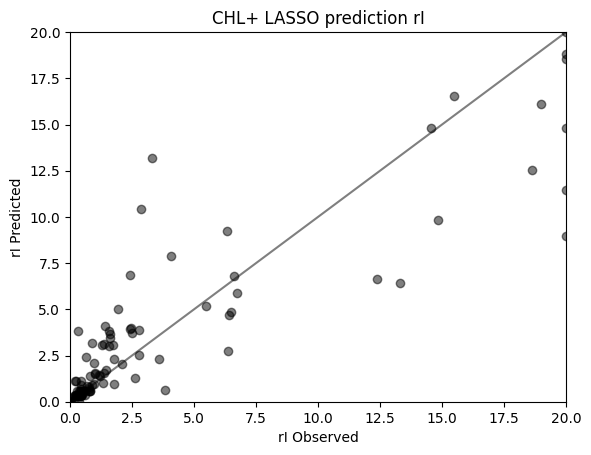

In [35]:

x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_POS[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_POS[native,pert, 1]
        y_nar[10*native + pert] = rA_grid[native, pert]
        y_nir[10*native + pert] = rI_grid[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.title('CHL+ LASSO prediction rA')
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.title('CHL+ LASSO prediction rI')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()


### Perform first order LASSO on CHL - data

In [36]:
##############################################################################
### Lasso for NAR, NIR CHL+ case

ALPHA = 0.01  # Regularization strength

clf_nar = []
clf_nir = []
for i in range(11):
    clf = linear_model.Lasso(alpha=ALPHA)
    clf.fit(X_NAR_CHL_NEG[:,i,:], Y_CHL_NEG[:,i,0])
    clf_nar.append(clf)
    clf = linear_model.Lasso(alpha=ALPHA)
    clf.fit(X_NIR_CHL_NEG[:,i,:], Y_CHL_NEG[:,i,1])
    clf_nir.append(clf)

print("--------------------------------------------------")
print("NAR")
for i in range(11):
    print(f"Coefficients {clf_nar[i].coef_.shape}:\n", clf_nar[i].coef_)
    print(f"Intercepts: {clf_nar[i].intercept_.shape}\n", clf_nar[i].intercept_)
print("--------------------------------------------------")

print("--------------------------------------------------")
print("NIR")
for i in range(11):
    print(f"Coefficients {clf_nir[i].coef_.shape}:\n", clf_nir[i].coef_)
    print(f"Intercepts: {clf_nir[i].intercept_.shape}\n", clf_nir[i].intercept_)
print("--------------------------------------------------")


--------------------------------------------------
NAR
Coefficients (8,):
 [ 0.         -0.          0.         -0.86162168  0.52035266 -0.
 -0.         -0.        ]
Intercepts: ()
 0.5519483475332638
Coefficients (8,):
 [ 0.02748101 -0.          0.         -0.47378764  0.13621013  0.
 -0.         -0.43583805]
Intercepts: ()
 0.6031482063637175
Coefficients (8,):
 [ 0.29028494 -0.          0.         -0.65168821 -0.02143305 -0.
  0.51043164  0.        ]
Intercepts: ()
 0.4637671682531448
Coefficients (8,):
 [ 0.08968768 -0.          0.         -0.49107223 -0.00864017  0.
  0.24931869 -0.        ]
Intercepts: ()
 0.5430822017929439
Coefficients (8,):
 [ 0.14020766 -0.          0.         -0.22844449 -0.00987132  0.
  0.24530745 -0.        ]
Intercepts: ()
 0.49496444480737223
Coefficients (8,):
 [ 0.         -0.          0.         -0.24001012  0.          0.
 -0.         -0.        ]
Intercepts: ()
 0.5719513265136283
Coefficients (8,):
 [ 0.         -0.          0.         -0.13271423

In [37]:
rA_grid = np.zeros((10,11))
rI_grid = np.zeros((10,11))
X_NIR_T0 = nir_rel_exp_chl_neg_t0
X_NAR_T0 = nar_rel_exp_chl_neg_t0
X_NIR_T9 = nir_rel_exp_chl_neg_t9
X_NAR_T9 = nar_rel_exp_chl_neg_t9
for native in tqdm.trange(10, desc="native", leave=False):
        for pert in tqdm.trange(11, desc="perturbed", leave=False):
            rA_pred = 0
            rI_pred = 0
            for i in range(len(group_idxs)):
                rA_pred += X_NAR_T0[native, pert, i]*clf_nar[pert].coef_[i]
                rI_pred += X_NIR_T0[native, pert, i]*clf_nir[pert].coef_[i]  
                rA_pred += X_NAR_T9[native, pert, i]*clf_nar[pert].coef_[i + len(group_idxs)]
                rI_pred += X_NIR_T9[native, pert, i]*clf_nir[pert].coef_[i + len(group_idxs)] 
            rA_pred += clf_nar[pert].intercept_
            rI_pred += clf_nir[pert].intercept_
            y_pred = [rA_pred, rI_pred]
            rA_grid[native, pert] = rA_pred
            rI_grid[native, pert] = rI_pred


native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

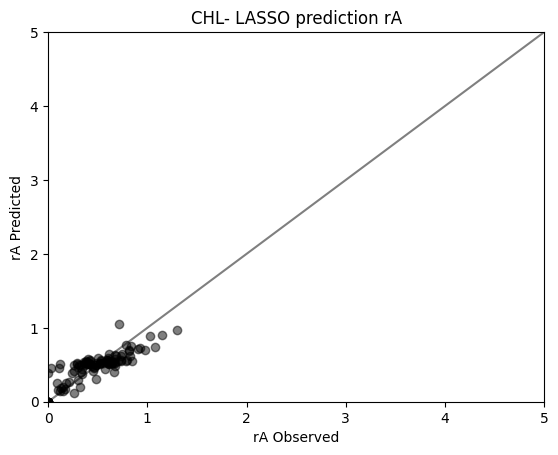

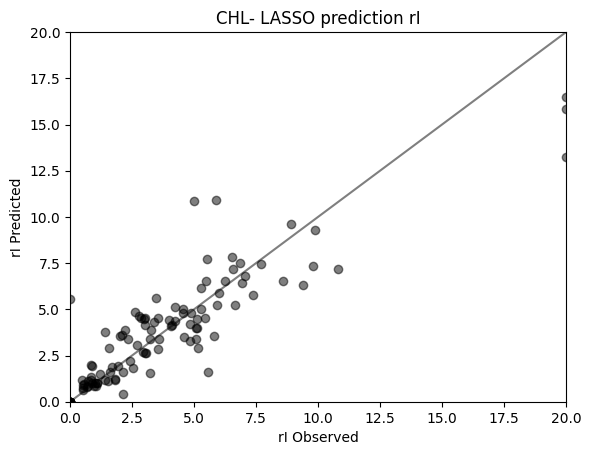

In [38]:

x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_NEG[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_NEG[native,pert, 1]
        y_nar[10*native + pert] = rA_grid[native, pert]
        y_nir[10*native + pert] = rI_grid[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.title('CHL- LASSO prediction rA')
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.title('CHL- LASSO prediction rI')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()


### Perform a leave one out cross validation, each row at a time. 

### First CHL+

In [41]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

ALPHA = 0.01 # Regularization strength
n_samples = X_NAR_CHL_POS.shape[0]  # How many native soils? 

# Store models and predictions for LOOCV
clf_nar_models = []  # Will store 11 lists (one per perturbation), each containing 10 models
clf_nir_models = []
nar_predictions = np.zeros_like(Y_CHL_POS[:, :, 0])  # Store predictions for evaluation
nir_predictions = np.zeros_like(Y_CHL_POS[:, :, 1])

# Loop over perturbations (11)
for i in range(11):
    nar_models_i = []
    nir_models_i = []
    
    # Loop over leave-one-out samples (10)
    for leave_out in range(n_samples):
        # Train NAR model (leave out 'leave_out' row)
        X_train_nar = np.delete(X_NAR_CHL_POS[:, i, :], leave_out, axis=0)
        Y_train_nar = np.delete(Y_CHL_POS[:, i, 0], leave_out)
        
        clf_nar = linear_model.Lasso(alpha=ALPHA)
        clf_nar.fit(X_train_nar, Y_train_nar)
        nar_models_i.append(clf_nar)
        
        # Predict on left-out sample
        nar_pred = clf_nar.predict(X_NAR_CHL_POS[leave_out, i, :].reshape(1, -1))
        nar_predictions[leave_out, i] = nar_pred
        
        # Train NIR model (leave out 'leave_out' row)
        X_train_nir = np.delete(X_NIR_CHL_POS[:, i, :], leave_out, axis=0)
        Y_train_nir = np.delete(Y_CHL_POS[:, i, 1], leave_out)
        
        clf_nir = linear_model.Lasso(alpha=ALPHA)
        clf_nir.fit(X_train_nir, Y_train_nir)
        nir_models_i.append(clf_nir)
        
        # Predict on left-out sample
        nir_pred = clf_nir.predict(X_NIR_CHL_POS[leave_out, i, :].reshape(1, -1))
        nir_predictions[leave_out, i] = nir_pred
    
    clf_nar_models.append(nar_models_i)
    clf_nir_models.append(nir_models_i)

# Evaluate performance (MSE per perturbation)
nar_mse = [mean_squared_error(Y_CHL_POS[:, i, 0], nar_predictions[:, i]) for i in range(11)]
nir_mse = [mean_squared_error(Y_CHL_POS[:, i, 1], nir_predictions[:, i]) for i in range(11)]

nar_predictions_chl_pos = nar_predictions
nir_predictions_chl_pos = nir_predictions

print("--------------------------------------------------")
print("NAR Mean Squared Errors (LOOCV):")
for i in range(11):
    print(f"Perturbation {i}: MSE = {nar_mse[i]:.4f}")
print("--------------------------------------------------")

print("NIR Mean Squared Errors (LOOCV):")
for i in range(11):
    print(f"Perturbation {i}: MSE = {nir_mse[i]:.4f}")
print("--------------------------------------------------")

--------------------------------------------------
NAR Mean Squared Errors (LOOCV):
Perturbation 0: MSE = 1.3809
Perturbation 1: MSE = 8.4426
Perturbation 2: MSE = 0.2137
Perturbation 3: MSE = 0.1132
Perturbation 4: MSE = 0.0689
Perturbation 5: MSE = 0.0521
Perturbation 6: MSE = 0.0258
Perturbation 7: MSE = 0.0154
Perturbation 8: MSE = 0.0155
Perturbation 9: MSE = 0.9885
Perturbation 10: MSE = 32.8865
--------------------------------------------------
NIR Mean Squared Errors (LOOCV):
Perturbation 0: MSE = 113.4174
Perturbation 1: MSE = 128.4924
Perturbation 2: MSE = 94.5225
Perturbation 3: MSE = 58.4409
Perturbation 4: MSE = 5.7700
Perturbation 5: MSE = 0.5608
Perturbation 6: MSE = 0.0416
Perturbation 7: MSE = 0.0174
Perturbation 8: MSE = 0.0077
Perturbation 9: MSE = 48.9918
Perturbation 10: MSE = 244.5995
--------------------------------------------------


/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_89835/2240741332.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nar_predictions[leave_out, i] = nar_pred
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_89835/2240741332.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nir_predictions[leave_out, i] = nir_pred
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_89835/2240741332.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  

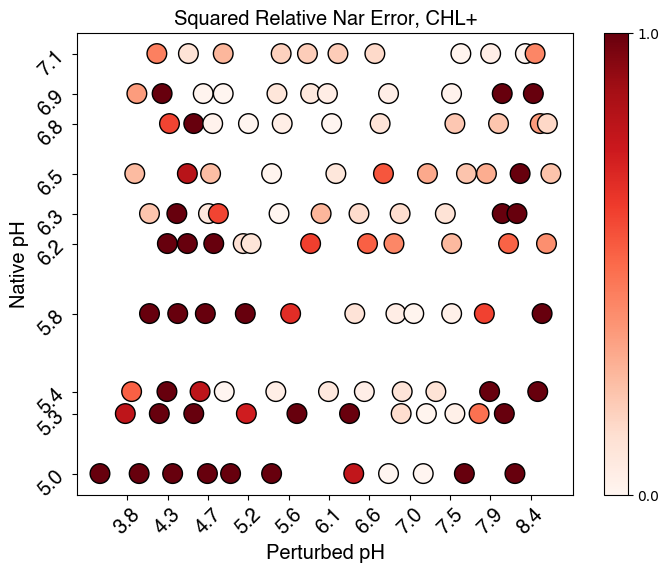

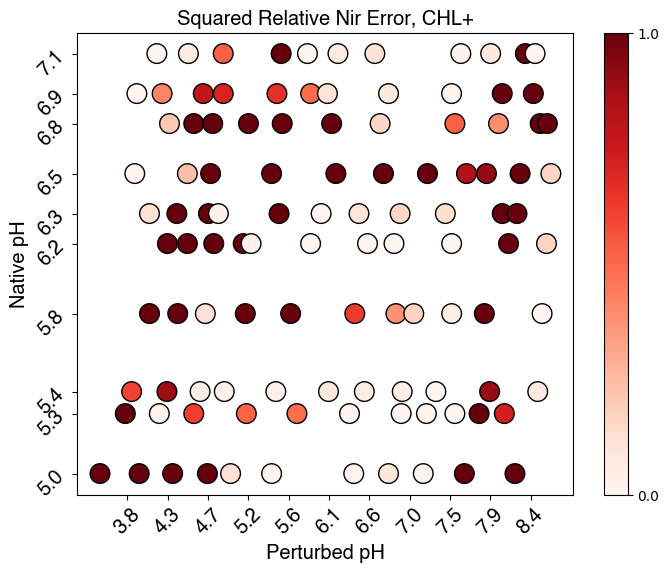

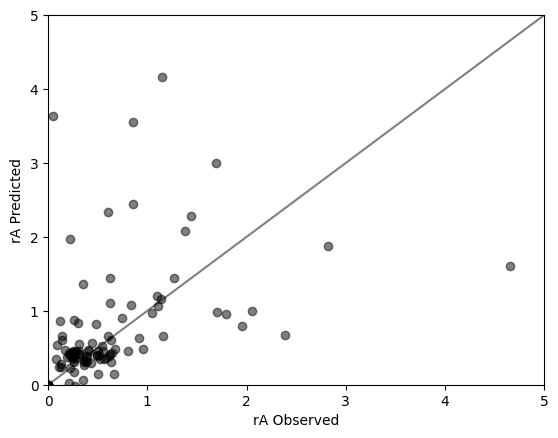

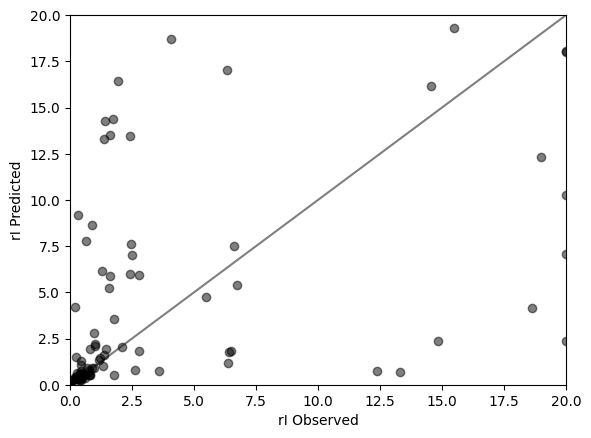

In [42]:
plot((nar_predictions - Y_CHL_POS[:, :, 0])**2/Y_CHL_POS[:, :, 0]**2, 'Squared Relative Nar Error, CHL+', cmap = 'Reds', vmin = 0, vmax = 1)
plot((nir_predictions - Y_CHL_POS[:, :, 1])**2/Y_CHL_POS[:, :, 1]**2, 'Squared Relative Nir Error, CHL+', cmap = 'Reds', vmin = 0, vmax = 1)


x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_POS[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_POS[native,pert, 1]
        y_nar[10*native + pert] = nar_predictions_chl_pos[native, pert]
        y_nir[10*native + pert] = nir_predictions_chl_pos[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()


### Now CHL-

In [74]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

ALPHA = 0.01  # Regularization strength
n_samples = X_NAR_CHL_NEG.shape[0]  # How many native samples? 

# Store models and predictions for LOOCV
clf_nar_models = []  # Will store 11 lists (one per perturbation), each containing 10 models
clf_nir_models = []
nar_predictions = np.zeros_like(Y_CHL_NEG[:, :, 0])  # Store predictions for evaluation
nir_predictions = np.zeros_like(Y_CHL_NEG[:, :, 1])

# Loop over perturbations (11)
for i in range(11):
    nar_models_i = []
    nir_models_i = []
    
    # Loop over leave-one-out samples (10)
    for leave_out in range(n_samples):
        # Train NAR model (leave out 'leave_out' row)
        X_train_nar = np.delete(X_NAR_CHL_NEG[:, i, :], leave_out, axis=0)
        Y_train_nar = np.delete(Y_CHL_NEG[:, i, 0], leave_out)
        
        clf_nar = linear_model.Lasso(alpha=ALPHA)
        clf_nar.fit(X_train_nar, Y_train_nar)
        nar_models_i.append(clf_nar)
        
        # Predict on left-out sample
        nar_pred = clf_nar.predict(X_NAR_CHL_NEG[leave_out, i, :].reshape(1, -1))
        nar_predictions[leave_out, i] = nar_pred[0]
        
        # Train NIR model (leave out 'leave_out' row)
        X_train_nir = np.delete(X_NIR_CHL_NEG[:, i, :], leave_out, axis=0)
        Y_train_nir = np.delete(Y_CHL_NEG[:, i, 1], leave_out)
        
        clf_nir = linear_model.Lasso(alpha=ALPHA)
        clf_nir.fit(X_train_nir, Y_train_nir)
        nir_models_i.append(clf_nir)
        
        # Predict on left-out sample
        nir_pred = clf_nir.predict(X_NIR_CHL_NEG[leave_out, i, :].reshape(1, -1))
        nir_predictions[leave_out, i] = nir_pred[0]
    
    clf_nar_models.append(nar_models_i)
    clf_nir_models.append(nir_models_i)

# Evaluate performance (MSE per perturbation)
nar_mse = [mean_squared_error(Y_CHL_NEG[:, i, 0], nar_predictions[:, i]) for i in range(11)]
nir_mse = [mean_squared_error(Y_CHL_NEG[:, i, 1], nir_predictions[:, i]) for i in range(11)]

nar_predictions_chl_neg = nar_predictions
nir_predictions_chl_neg = nir_predictions

print("--------------------------------------------------")
print("NAR Mean Squared Errors (LOOCV):")
for i in range(11):
    print(f"Perturbation {i}: MSE = {nar_mse[i]:.4f}")
print("--------------------------------------------------")

print("NIR Mean Squared Errors (LOOCV):")
for i in range(11):
    print(f"Perturbation {i}: MSE = {nir_mse[i]:.4f}")
print("--------------------------------------------------")

--------------------------------------------------
NAR Mean Squared Errors (LOOCV):
Perturbation 0: MSE = 0.1487
Perturbation 1: MSE = 0.0392
Perturbation 2: MSE = 0.0802
Perturbation 3: MSE = 0.0546
Perturbation 4: MSE = 0.0789
Perturbation 5: MSE = 0.0389
Perturbation 6: MSE = 0.0460
Perturbation 7: MSE = 0.0187
Perturbation 8: MSE = 0.0263
Perturbation 9: MSE = 0.0150
Perturbation 10: MSE = 0.0019
--------------------------------------------------
NIR Mean Squared Errors (LOOCV):
Perturbation 0: MSE = 113.8504
Perturbation 1: MSE = 63.5039
Perturbation 2: MSE = 3.8262
Perturbation 3: MSE = 7.0794
Perturbation 4: MSE = 16.8322
Perturbation 5: MSE = 10.9451
Perturbation 6: MSE = 6.3053
Perturbation 7: MSE = 1.4717
Perturbation 8: MSE = 0.7023
Perturbation 9: MSE = 0.1042
Perturbation 10: MSE = 0.4419
--------------------------------------------------


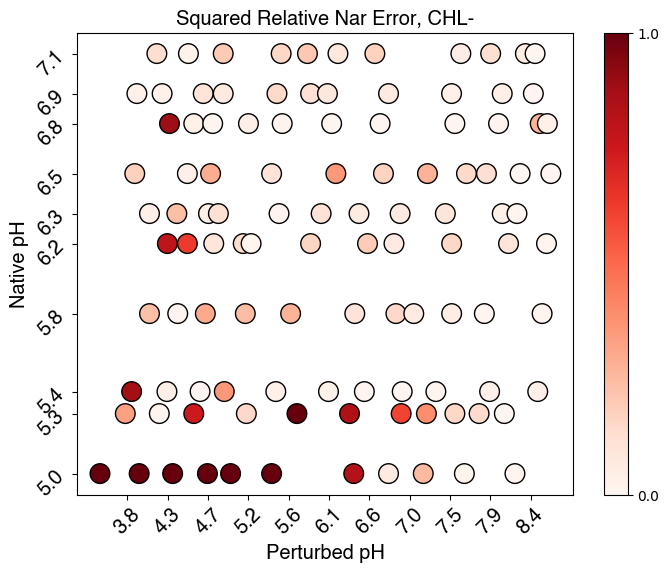

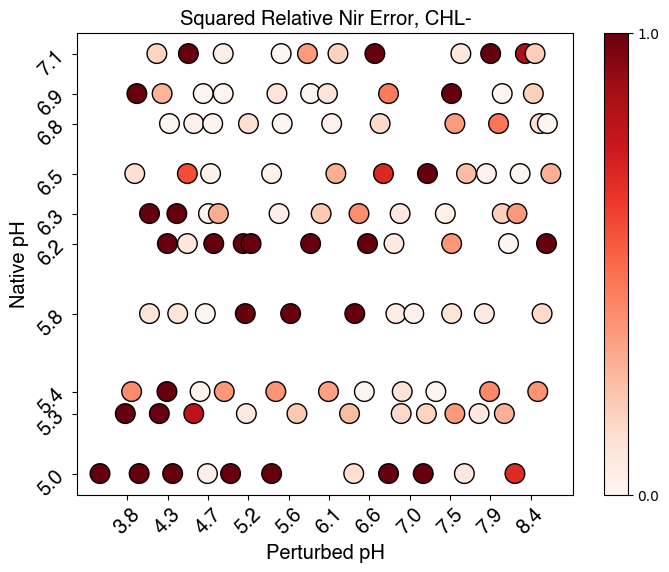

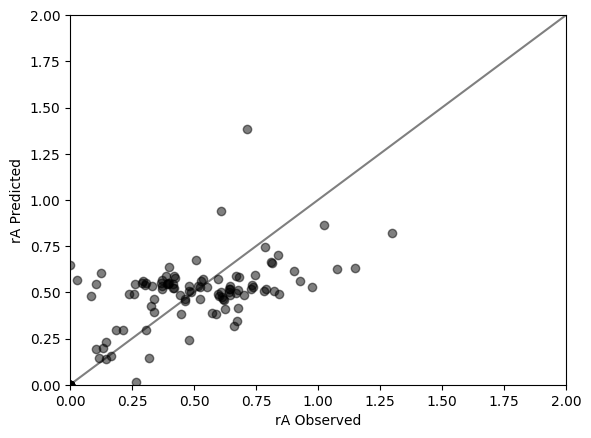

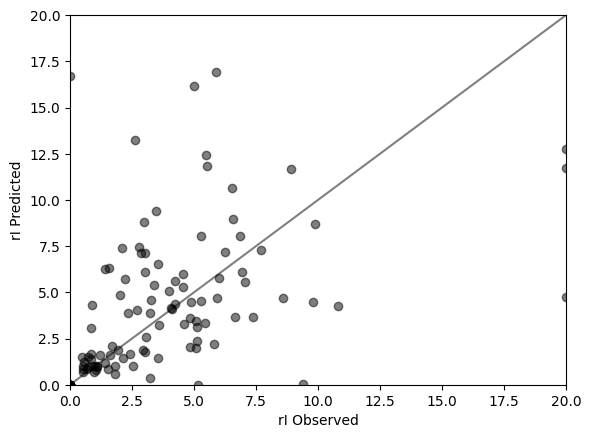

In [44]:
plot((nar_predictions - Y_CHL_NEG[:, :, 0])**2/Y_CHL_NEG[:, :, 0]**2, 'Squared Relative Nar Error, CHL-', cmap = 'Reds', vmin = 0, vmax = 1)
plot((nir_predictions - Y_CHL_NEG[:, :, 1])**2/Y_CHL_NEG[:, :, 1]**2, 'Squared Relative Nir Error, CHL-', cmap = 'Reds', vmin = 0, vmax = 1)

x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_NEG[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_NEG[native,pert, 1]
        y_nar[10*native + pert] = nar_predictions_chl_neg[native, pert]
        y_nir[10*native + pert] = nir_predictions_chl_neg[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.xlim(0,2)
plt.ylim(0,2)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()

### Simulate Cross Validated (parameter free) Predictions

In [45]:
def RHS(y, params):
    x, A, I, C = y
    gamma_A, gamma_I, r_A, r_I, K_A, K_I, K_C = params

    dx = r_A*(gamma_A*r_A*A/(K_A + A) + gamma_I*r_I*I/(K_I + I))*x*C/(K_C + C)
    dA = -r_A*x*A/(K_A + A)
    dI = (r_A*A/(K_A + A) - r_I*I/(K_I + I))*x
    dC = - x*C/(K_C + C)
    
    dydt = np.array([dx, dA, dI, dC])
    return dydt


native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

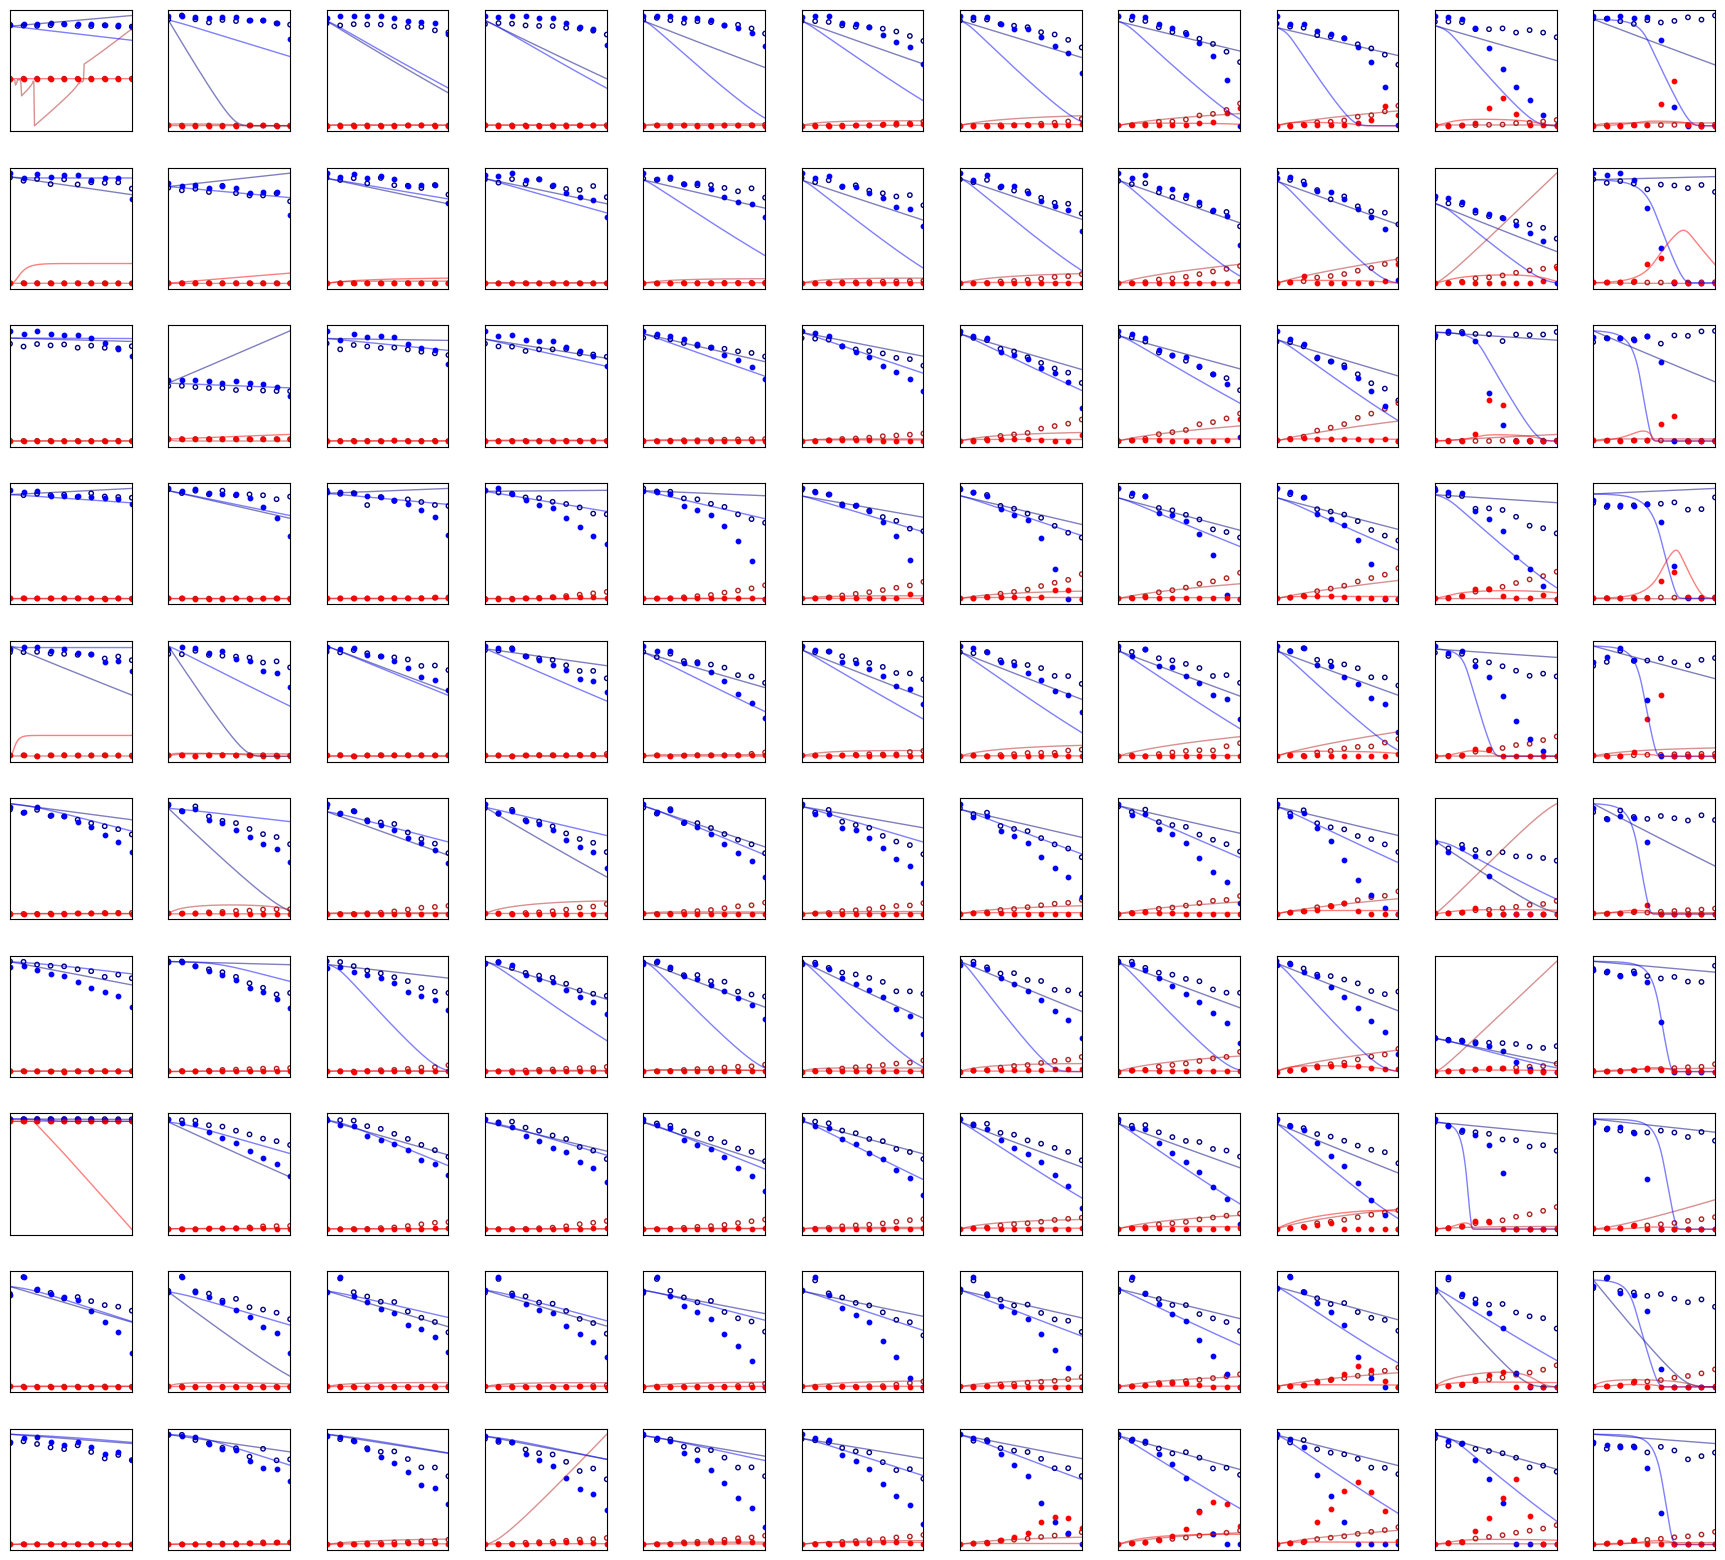

In [46]:
from mgsa.modeling import simulate 
import tqdm.notebook as tqdm


fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

A_0 = 2
I_0 = 0
K_A = 0.1
K_I = 0.1
K_C = 0.1
dt = 0.05
T = 9
gamma = 5

c0 = pd.read_csv('../out/metabolic_parameters/inferred_c0.tsv', sep = '\t', header=None).values
x0 = pd.read_csv('../out/metabolic_parameters/inferred_x0.tsv', sep = '\t', header=None).values

N = int(T/dt)


for native in tqdm.trange(10, desc = 'native'): 
    for pert in tqdm.trange(11, desc = 'perturbed'):  
        
        x_0 = x0[native, pert]
        C_0 = c0[native, pert]

        sample = samples_from_soils(soils[9 - native])[pert]
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        y0 = np.array([x_0, A_0, I_0, C_0])
        params = [0, 0, nar_predictions_chl_pos[native, pert], nir_predictions_chl_pos[native, pert],  K_A, K_I, K_C]
        x, A, I, C = simulate(RHS, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        

        y0 = np.array([x_0, A_0, I_0, C_0])
        params = [gamma, gamma, nar_predictions_chl_neg[native, pert], nir_predictions_chl_neg[native, pert], K_A, K_I, K_C]
        x, A, I, C = simulate(RHS, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

### Now instead, try fitting on all of the data.

why?: because 9 points is too little to train on.

In [ ]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

ALPHA = 1  # Regularization strength

# Flatten data
X_nar_all = X_NAR_CHL_POS.reshape(-1, X_NAR_CHL_POS.shape[-1])  # (110, number clusters)
X_nir_all = X_NIR_CHL_POS.reshape(-1, X_NIR_CHL_POS.shape[-1])  # (110, number clusters)
y_nar_all = Y_CHL_POS[:, :, 0].flatten()  # (110,)
y_nir_all = Y_CHL_POS[:, :, 1].flatten()  # (110,)

# Initialize prediction arrays
nar_predictions = np.zeros_like(y_nar_all)
nir_predictions = np.zeros_like(y_nir_all)

# Leave-one-out CV over ALL 110 points
for i in range(len(y_nar_all)):
    # Train NAR model on all points EXCEPT i
    X_train = np.delete(X_nar_all, i, axis=0)
    y_train = np.delete(y_nar_all, i)
    clf = linear_model.Lasso(alpha=ALPHA).fit(X_train, y_train)
    nar_predictions[i] = clf.predict(X_nar_all[i].reshape(1, -1))
    
    # Train NIR model on all points EXCEPT i
    X_train = np.delete(X_nir_all, i, axis=0)
    y_train = np.delete(y_nir_all, i)
    clf = linear_model.Lasso(alpha=ALPHA).fit(X_train, y_train)
    nir_predictions[i] = clf.predict(X_nir_all[i].reshape(1, -1))

# Reshape predictions back to (10, 11) for per-perturbation analysis
nar_predictions = nar_predictions.reshape(10, 11)
nir_predictions = nir_predictions.reshape(10, 11)

nar_predictions_chl_pos = nar_predictions
nir_predictions_chl_pos = nir_predictions

# Compute errors (MSE and MAE per perturbation)
nar_mse = [mean_squared_error(Y_CHL_POS[:, i, 0], nar_predictions[:, i]) for i in range(11)]
nir_mse = [mean_squared_error(Y_CHL_POS[:, i, 1], nir_predictions[:, i]) for i in range(11)]

nar_mae = [mean_absolute_error(Y_CHL_POS[:, i, 0], nar_predictions[:, i]) for i in range(11)]
nir_mae = [mean_absolute_error(Y_CHL_POS[:, i, 1], nir_predictions[:, i]) for i in range(11)]

print("NAR Mean Squared Error:")
print(np.round(nar_mse, 4))
print("\nNIR Mean Squared Error:")
print(np.round(nir_mse, 4))

/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_89835/487772343.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nar_predictions[i] = clf.predict(X_nar_all[i].reshape(1, -1))
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_89835/487772343.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nir_predictions[i] = clf.predict(X_nir_all[i].reshape(1, -1))
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_89835/487772343.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

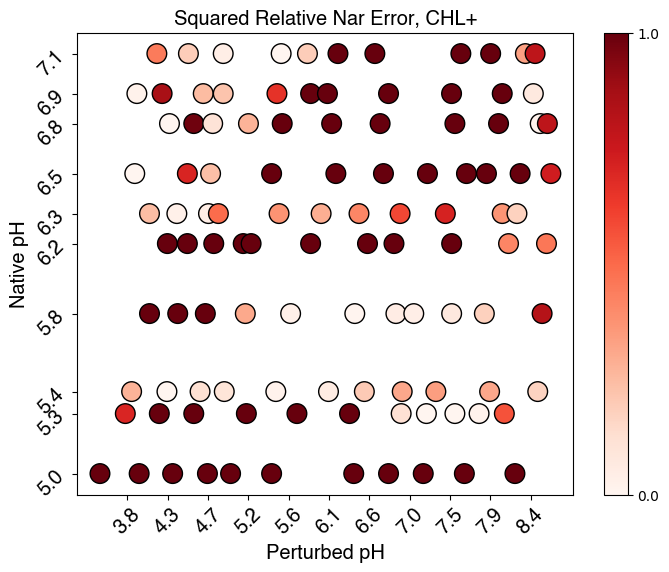

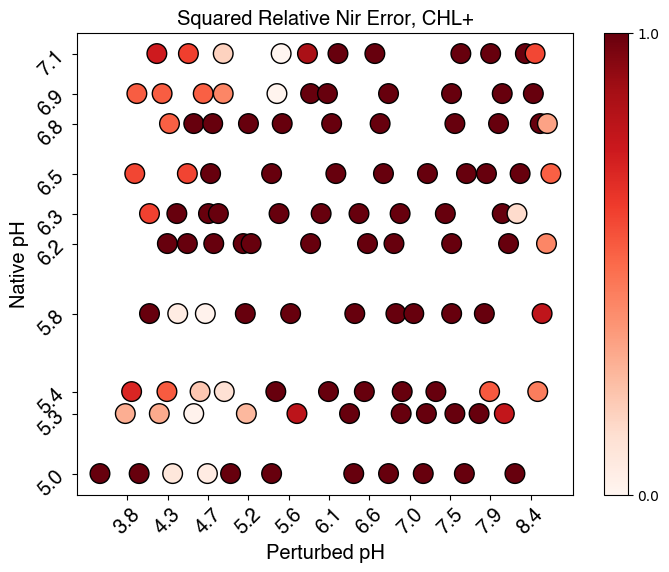

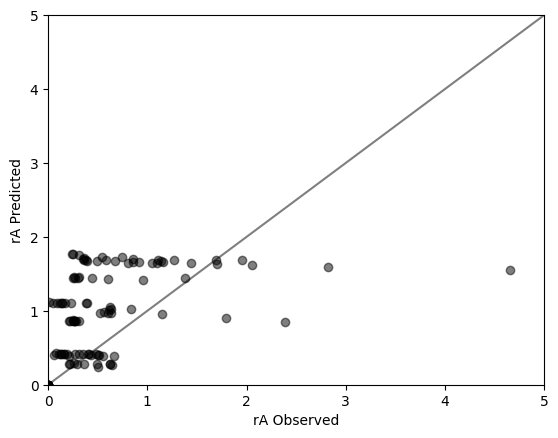

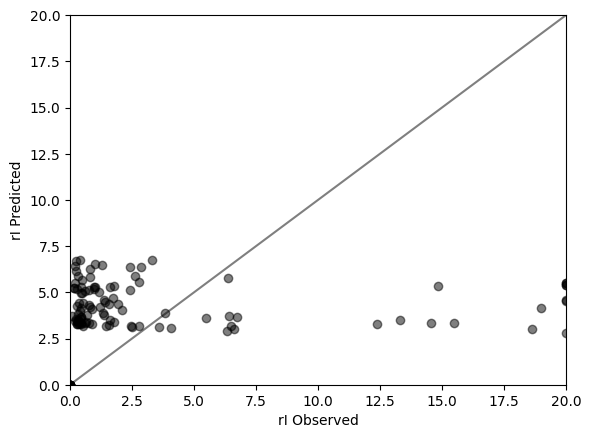

In [60]:
plot((nar_predictions_chl_pos - Y_CHL_POS[:, :, 0])**2/Y_CHL_POS[:, :, 0]**2, 'Squared Relative Nar Error, CHL+', cmap = 'Reds', vmin = 0, vmax = 1)
plot((nir_predictions_chl_pos - Y_CHL_POS[:, :, 1])**2/Y_CHL_POS[:, :, 1]**2, 'Squared Relative Nir Error, CHL+', cmap = 'Reds', vmin = 0, vmax = 1)


x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_POS[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_POS[native,pert, 1]
        y_nar[10*native + pert] = nar_predictions_chl_pos[native, pert]
        y_nir[10*native + pert] = nir_predictions_chl_pos[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()


In [90]:

ALPHA = 0.001  # Regularization strength

# Flatten data
X_nar_all = X_NAR_CHL_NEG.reshape(-1, X_NAR_CHL_NEG.shape[-1])  # (110, number clusters)
X_nir_all = X_NIR_CHL_NEG.reshape(-1, X_NIR_CHL_NEG.shape[-1])  # (110, number clusters)
y_nar_all = Y_CHL_NEG[:, :, 0].flatten()  # (110,)
y_nir_all = Y_CHL_NEG[:, :, 1].flatten()  # (110,)

# Initialize prediction arrays
nar_predictions = np.zeros_like(y_nar_all)
nir_predictions = np.zeros_like(y_nir_all)

# Leave-one-out CV over ALL 110 points
for i in range(len(y_nar_all)):
    # Train NAR model on all points EXCEPT i
    X_train = np.delete(X_nar_all, i, axis=0)
    y_train = np.delete(y_nar_all, i)
    clf = linear_model.Lasso(alpha=ALPHA).fit(X_train, y_train)
    nar_predictions[i] = clf.predict(X_nar_all[i].reshape(1, -1))[0]
    
    # Train NIR model on all points EXCEPT i
    X_train = np.delete(X_nir_all, i, axis=0)
    y_train = np.delete(y_nir_all, i)
    clf = linear_model.Lasso(alpha=ALPHA).fit(X_train, y_train)
    nir_predictions[i] = clf.predict(X_nir_all[i].reshape(1, -1))[0]

# Reshape predictions back to (10, 11) for per-perturbation analysis
nar_predictions = nar_predictions.reshape(10, 11)
nir_predictions = nir_predictions.reshape(10, 11)

nar_predictions_chl_neg = nar_predictions
nir_predictions_chl_neg = nir_predictions

# Compute errors (MSE and MAE per perturbation)
nar_mse = [mean_squared_error(Y_CHL_NEG[:, i, 0], nar_predictions[:, i]) for i in range(11)]
nir_mse = [mean_squared_error(Y_CHL_NEG[:, i, 1], nir_predictions[:, i]) for i in range(11)]

nar_mae = [mean_absolute_error(Y_CHL_NEG[:, i, 0], nar_predictions[:, i]) for i in range(11)]
nir_mae = [mean_absolute_error(Y_CHL_NEG[:, i, 1], nir_predictions[:, i]) for i in range(11)]

print("NAR Mean Squared Error (LOOCV pooled):")
print(np.round(nar_mse, 4))
print("\nNIR Mean Squared Error (LOOCV pooled):")
print(np.round(nir_mse, 4))

NAR Mean Squared Error (LOOCV pooled):
[0.1353 0.0363 0.0699 0.0342 0.0463 0.0238 0.0337 0.0204 0.0252 0.0271
 0.0201]

NIR Mean Squared Error (LOOCV pooled):
[82.255  28.5036  6.3092  4.1535  7.2208  3.659   3.1605  4.0949 10.4388
 13.6147 10.947 ]


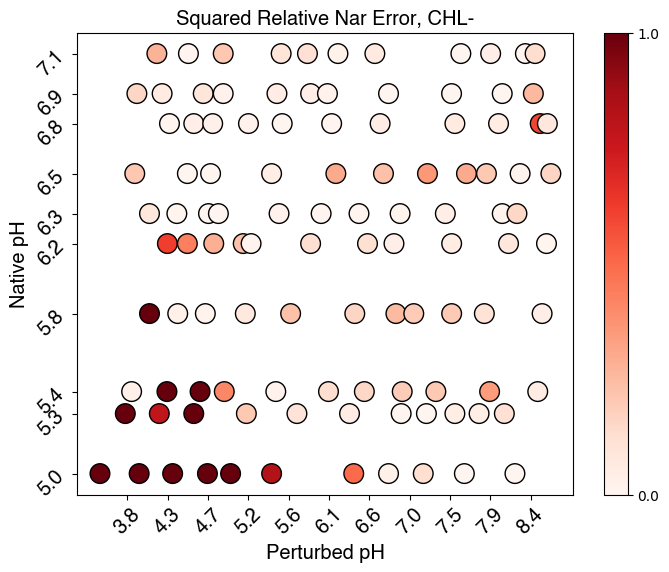

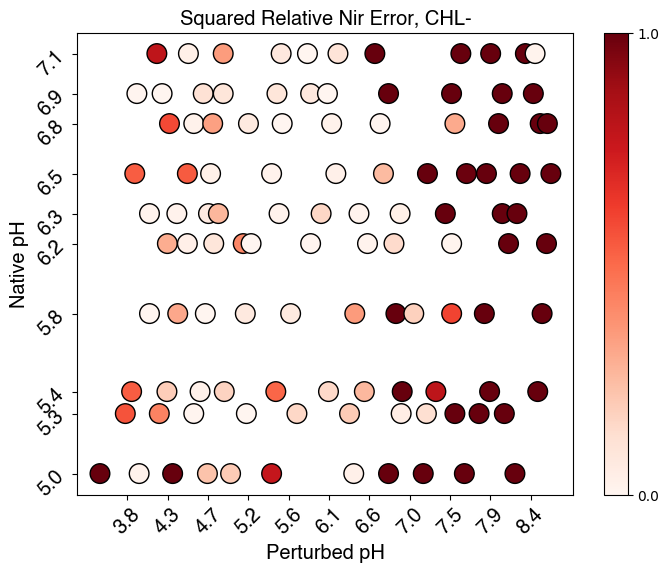

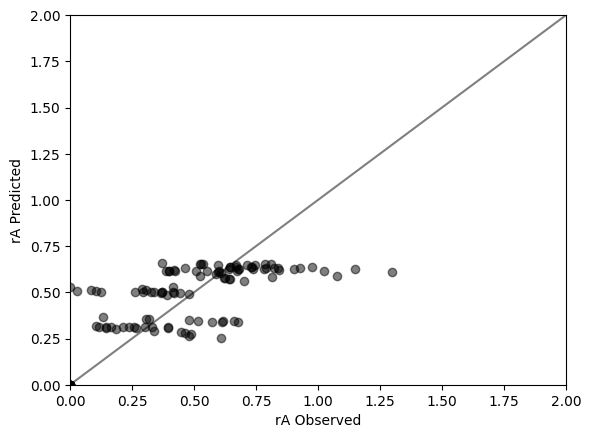

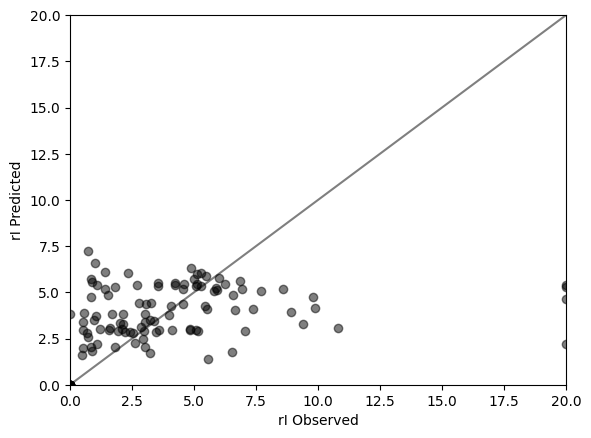

In [89]:
plot((nar_predictions_chl_neg - Y_CHL_NEG[:, :, 0])**2/Y_CHL_NEG[:, :, 0]**2, 'Squared Relative Nar Error, CHL-', cmap = 'Reds', vmin = 0, vmax = 1)
plot((nir_predictions_chl_neg - Y_CHL_NEG[:, :, 1])**2/Y_CHL_NEG[:, :, 1]**2, 'Squared Relative Nir Error, CHL-', cmap = 'Reds', vmin = 0, vmax = 1)

x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_NEG[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_NEG[native,pert, 1]
        y_nar[10*native + pert] = nar_predictions_chl_neg[native, pert]
        y_nir[10*native + pert] = nir_predictions_chl_neg[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.xlim(0,2)
plt.ylim(0,2)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()

native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

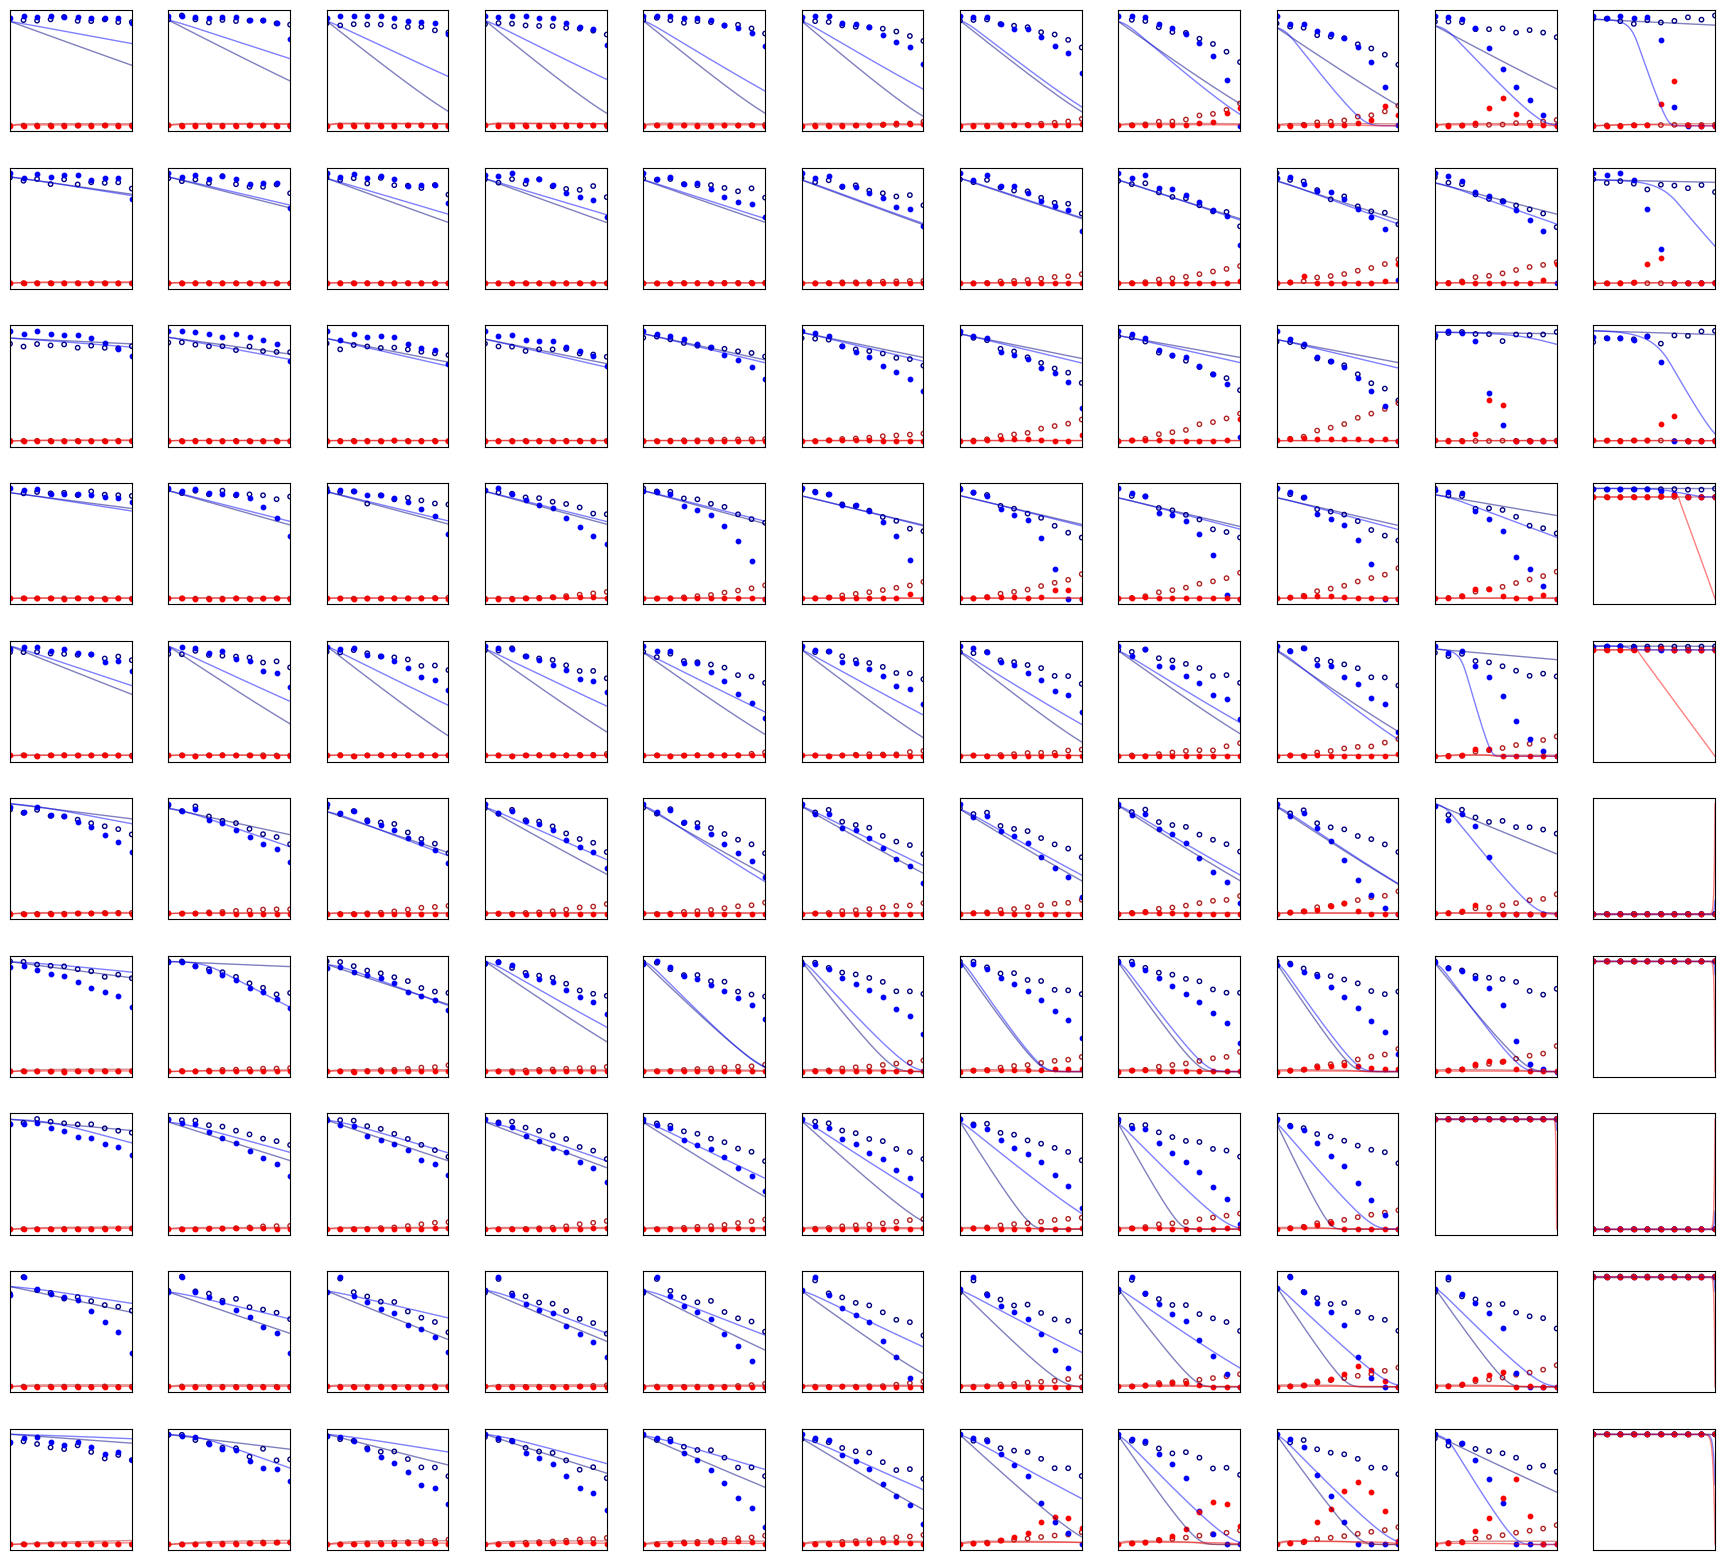

In [63]:
from mgsa.modeling import simulate 
import tqdm.notebook as tqdm


fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

A_0 = 2
I_0 = 0
K_A = 0.1
K_I = 0.1
K_C = 0.1
dt = 0.05
T = 9
gamma = 5

c0 = pd.read_csv('../out/metabolic_parameters/inferred_c0.tsv', sep = '\t', header=None).values
x0 = pd.read_csv('../out/metabolic_parameters/inferred_x0.tsv', sep = '\t', header=None).values

N = int(T/dt)


for native in tqdm.trange(10, desc = 'native'): 
    for pert in tqdm.trange(11, desc = 'perturbed'):  
        
        x_0 = x0[native, pert]
        C_0 = c0[native, pert]

        sample = samples_from_soils(soils[9 - native])[pert]
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        y0 = np.array([x_0, A_0, I_0, C_0])
        params = [0, 0, nar_predictions_chl_pos[native, pert], nir_predictions_chl_pos[native, pert],  K_A, K_I, K_C]
        x, A, I, C = simulate(RHS, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        

        y0 = np.array([x_0, A_0, I_0, C_0])
        params = [gamma, gamma, nar_predictions_chl_neg[native, pert], nir_predictions_chl_neg[native, pert], K_A, K_I, K_C]
        x, A, I, C = simulate(RHS, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()

### Lastly, train on all other elements within a designed perturbed pH group

In [75]:


# Define groups
groups = [
    [0, 1],    # acidic group
    [2, 3, 4, 5, 6, 7, 8],     
    [9, 10]        # basic group
]

ALPHA = 0.01
n_samples = X_NAR_CHL_POS.shape[0]  # Number of native samples (10)

# Initialize prediction arrays
nar_predictions = np.zeros_like(Y_CHL_POS[:, :, 0])  # (10, 11)
nir_predictions = np.zeros_like(Y_CHL_POS[:, :, 1])   # (10, 11)

# Loop over all perturbations and natives
for pert in range(11):
    # Find which group this perturbation belongs to
    current_group = None
    for group in groups:
        if pert in group:
            current_group = group
            break
    
    for native in range(n_samples):
        # Create a mask for all samples in the current group (shape: [n_samples, len(current_group)])
        mask = np.ones((n_samples, len(current_group)), dtype=bool)
        
        # Find the position of 'pert' in 'current_group'
        pert_idx_in_group = current_group.index(pert)
        
        # Exclude the current (native, pert) point
        mask[native, pert_idx_in_group] = False
        
        # Get training data (only from this group, excluding the left-out point)
        X_train_nar = X_NAR_CHL_POS[:, current_group, :][mask].reshape(-1, X_NAR_CHL_POS.shape[-1])
        Y_train_nar = Y_CHL_POS[:, current_group, 0][mask].flatten()
        
        # Train and predict NAR
        clf_nar = linear_model.Lasso(alpha=ALPHA).fit(X_train_nar, Y_train_nar)
        nar_predictions[native, pert] = clf_nar.predict(
            X_NAR_CHL_POS[native, pert, :].reshape(1, -1))[0]
        
        # Train and predict NIR
        X_train_nir = X_NIR_CHL_POS[:, current_group, :][mask].reshape(-1, X_NIR_CHL_POS.shape[-1])
        Y_train_nir = Y_CHL_POS[:, current_group, 1][mask].flatten()
        
        clf_nir = linear_model.Lasso(alpha=ALPHA).fit(X_train_nir, Y_train_nir)
        nir_predictions[native, pert] = clf_nir.predict(
            X_NIR_CHL_POS[native, pert, :].reshape(1, -1))[0]
        
nar_predictions_chl_pos = nar_predictions
nir_predictions_chl_pos = nir_predictions

# Compute errors per perturbation
nar_mse = [mean_squared_error(Y_CHL_POS[:, i, 0], nar_predictions[:, i]) for i in range(11)]
nir_mse = [mean_squared_error(Y_CHL_POS[:, i, 1], nir_predictions[:, i]) for i in range(11)]

print("NAR MSE (Within-Group LOO):", np.round(nar_mse, 4))
print("NIR MSE (Within-Group LOO):", np.round(nir_mse, 4))

NAR MSE (Within-Group LOO): [ 1.3217  5.1548  0.355   0.2017  0.0696  0.0345  0.0451  0.0626  0.0689
  7.23   26.9131]
NIR MSE (Within-Group LOO): [ 68.9237  85.7893  39.3163  20.4969   2.2253   1.1728   2.7423   3.2261
   3.2442  66.9872 126.926 ]


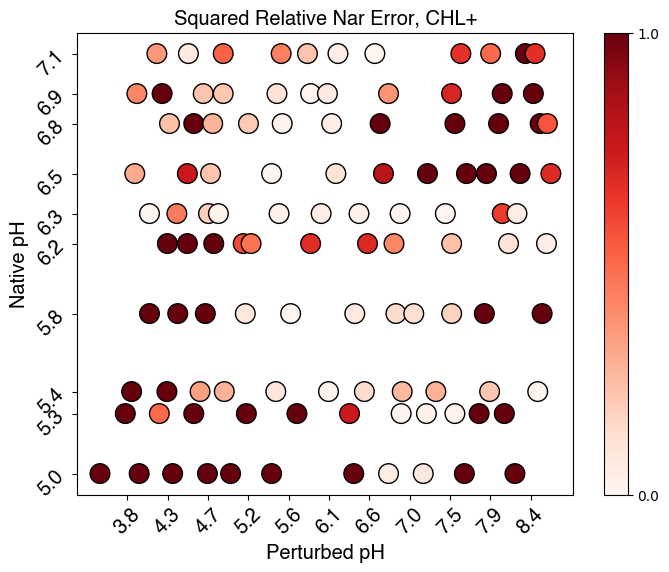

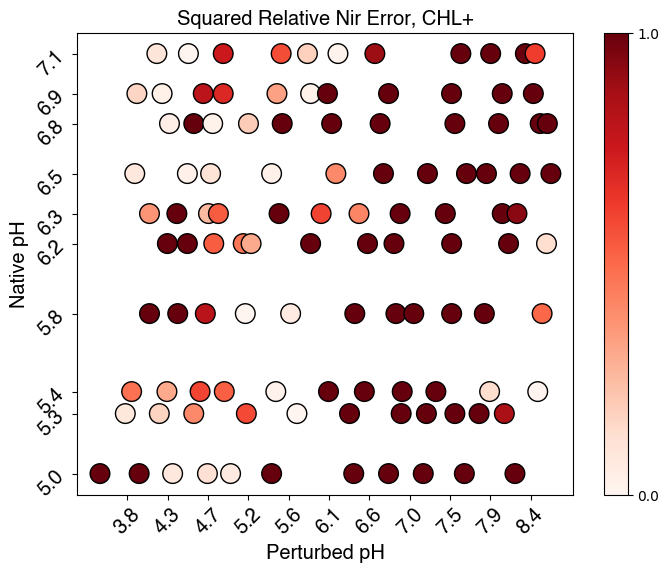

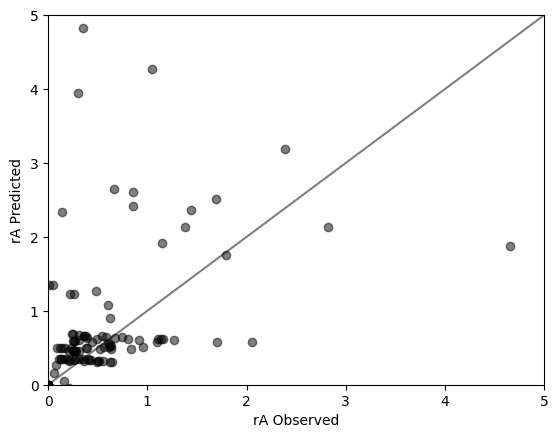

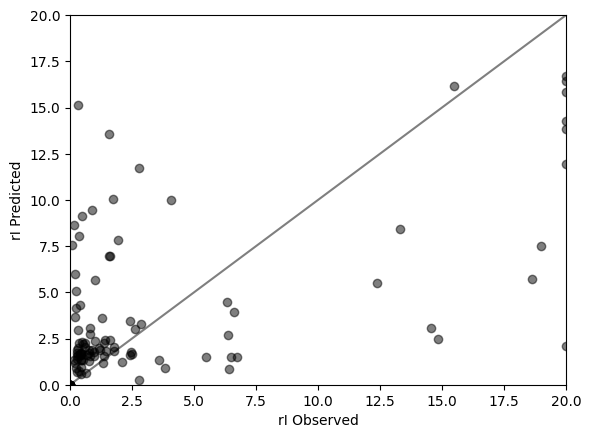

In [65]:
plot((nar_predictions_chl_pos - Y_CHL_POS[:, :, 0])**2/Y_CHL_POS[:, :, 0]**2, 'Squared Relative Nar Error, CHL+', cmap = 'Reds', vmin = 0, vmax = 1)
plot((nir_predictions_chl_pos - Y_CHL_POS[:, :, 1])**2/Y_CHL_POS[:, :, 1]**2, 'Squared Relative Nir Error, CHL+', cmap = 'Reds', vmin = 0, vmax = 1)


x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_POS[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_POS[native,pert, 1]
        y_nar[10*native + pert] = nar_predictions_chl_pos[native, pert]
        y_nir[10*native + pert] = nir_predictions_chl_pos[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()


In [76]:


# Define groups 
groups = [
    [0, 1],    # acid group
    [2, 3, 4, 5, 6, 7, 8],
    [9, 10]        # basic group
]

ALPHA = 0.001
n_samples = X_NAR_CHL_NEG.shape[0]  # Number of native samples (10)

# Initialize prediction arrays
nar_predictions = np.zeros_like(Y_CHL_NEG[:, :, 0])  # (10, 11)
nir_predictions = np.zeros_like(Y_CHL_NEG[:, :, 1])   # (10, 11)

# Loop over all perturbations and natives
for pert in range(11):
    # Find which group this perturbation belongs to
    current_group = None
    for group in groups:
        if pert in group:
            current_group = group
            break
    
    for native in range(n_samples):
        # Create a mask for all samples in the current group 
        mask = np.ones((n_samples, len(current_group)), dtype=bool)
        
        # Find the position of 'pert' in 'current_group'
        pert_idx_in_group = current_group.index(pert)
        
        # Exclude the current (native, pert) point
        mask[native, pert_idx_in_group] = False
        
        # Get training data (only from this group, excluding the left-out point)
        X_train_nar = X_NAR_CHL_NEG[:, current_group, :][mask].reshape(-1, X_NAR_CHL_NEG.shape[-1])
        Y_train_nar = Y_CHL_NEG[:, current_group, 0][mask].flatten()
        
        # Train and predict NAR
        clf_nar = linear_model.Lasso(alpha=ALPHA).fit(X_train_nar, Y_train_nar)
        nar_predictions[native, pert] = clf_nar.predict(
            X_NAR_CHL_NEG[native, pert, :].reshape(1, -1))[0]
        
        # Train and predict NIR
        X_train_nir = X_NIR_CHL_NEG[:, current_group, :][mask].reshape(-1, X_NIR_CHL_NEG.shape[-1])
        Y_train_nir = Y_CHL_NEG[:, current_group, 1][mask].flatten()
        
        clf_nir = linear_model.Lasso(alpha=ALPHA).fit(X_train_nir, Y_train_nir)
        nir_predictions[native, pert] = clf_nir.predict(
            X_NIR_CHL_NEG[native, pert, :].reshape(1, -1))[0]
        
nar_predictions_chl_neg = nar_predictions
nir_predictions_chl_neg = nir_predictions


# Compute errors per perturbation
nar_mse = [mean_squared_error(Y_CHL_NEG[:, i, 0], nar_predictions[:, i]) for i in range(11)]
nir_mse = [mean_squared_error(Y_CHL_NEG[:, i, 1], nir_predictions[:, i]) for i in range(11)]

print("NAR MSE (Within-Group LOO):", np.round(nar_mse, 4))
print("NIR MSE (Within-Group LOO):", np.round(nir_mse, 4))

NAR MSE (Within-Group LOO): [0.0698 0.0327 0.0697 0.0262 0.034  0.0238 0.034  0.0176 0.0234 0.016
 0.0044]
NIR MSE (Within-Group LOO): [76.469  45.2689  8.3596  4.7771  7.9508  3.5545  3.0948  3.092   9.3321
  0.1125  0.4174]


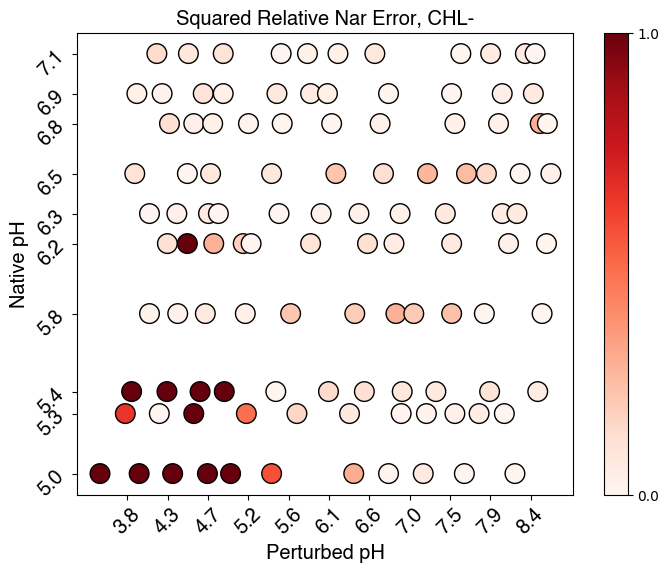

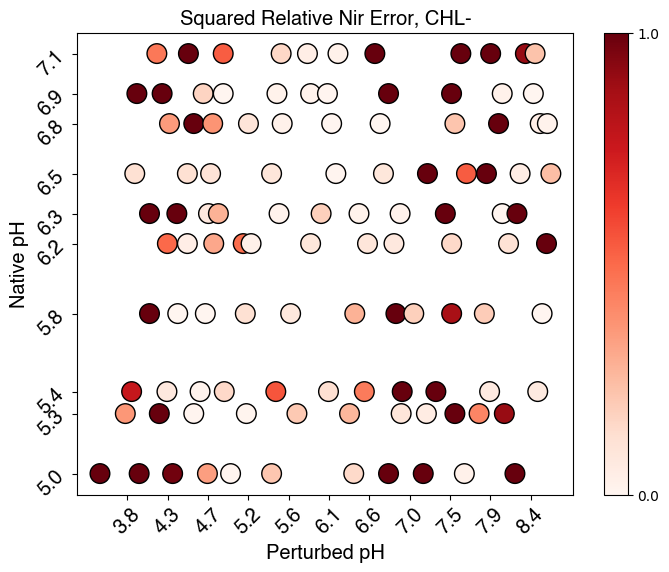

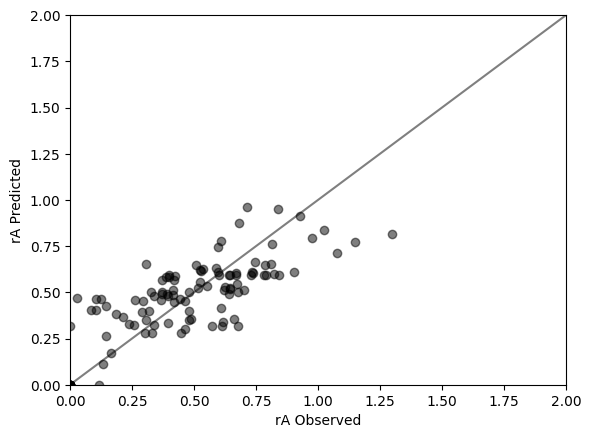

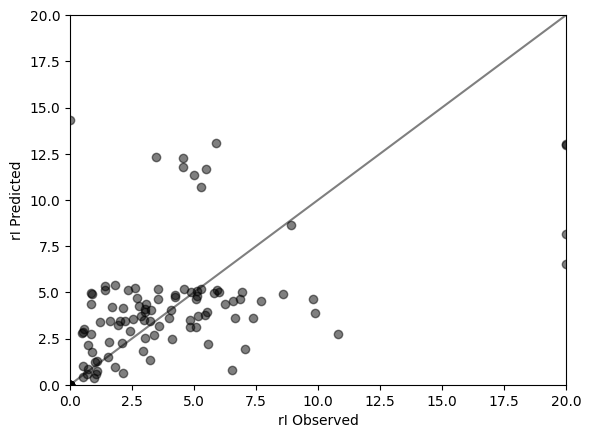

In [70]:
plot((nar_predictions_chl_neg - Y_CHL_NEG[:, :, 0])**2/Y_CHL_NEG[:, :, 0]**2, 'Squared Relative Nar Error, CHL-', cmap = 'Reds', vmin = 0, vmax = 1)
plot((nir_predictions_chl_neg - Y_CHL_NEG[:, :, 1])**2/Y_CHL_NEG[:, :, 1]**2, 'Squared Relative Nir Error, CHL-', cmap = 'Reds', vmin = 0, vmax = 1)

x_nar = np.zeros(110)
y_nar = np.zeros(110)
x_nir = np.zeros(110)
y_nir = np.zeros(110)
x = np.linspace(0,20,10)
y = np.linspace(0,20,10)
for native in range(10):
    for pert in range(11):
        x_nar[10*native + pert] = Y_CHL_NEG[native,pert, 0]
        x_nir[10*native + pert] = Y_CHL_NEG[native,pert, 1]
        y_nar[10*native + pert] = nar_predictions_chl_neg[native, pert]
        y_nir[10*native + pert] = nir_predictions_chl_neg[native, pert]
        
plt.scatter(x_nar, y_nar, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rA Observed')
plt.ylabel('rA Predicted')
plt.xlim(0,2)
plt.ylim(0,2)
plt.show()
plt.scatter(x_nir, y_nir, color = 'Black', alpha = 0.5)
plt.plot(x,y, color = 'Black', alpha = 0.5)
plt.xlabel('rI Observed')
plt.ylabel('rI Predicted')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()

native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

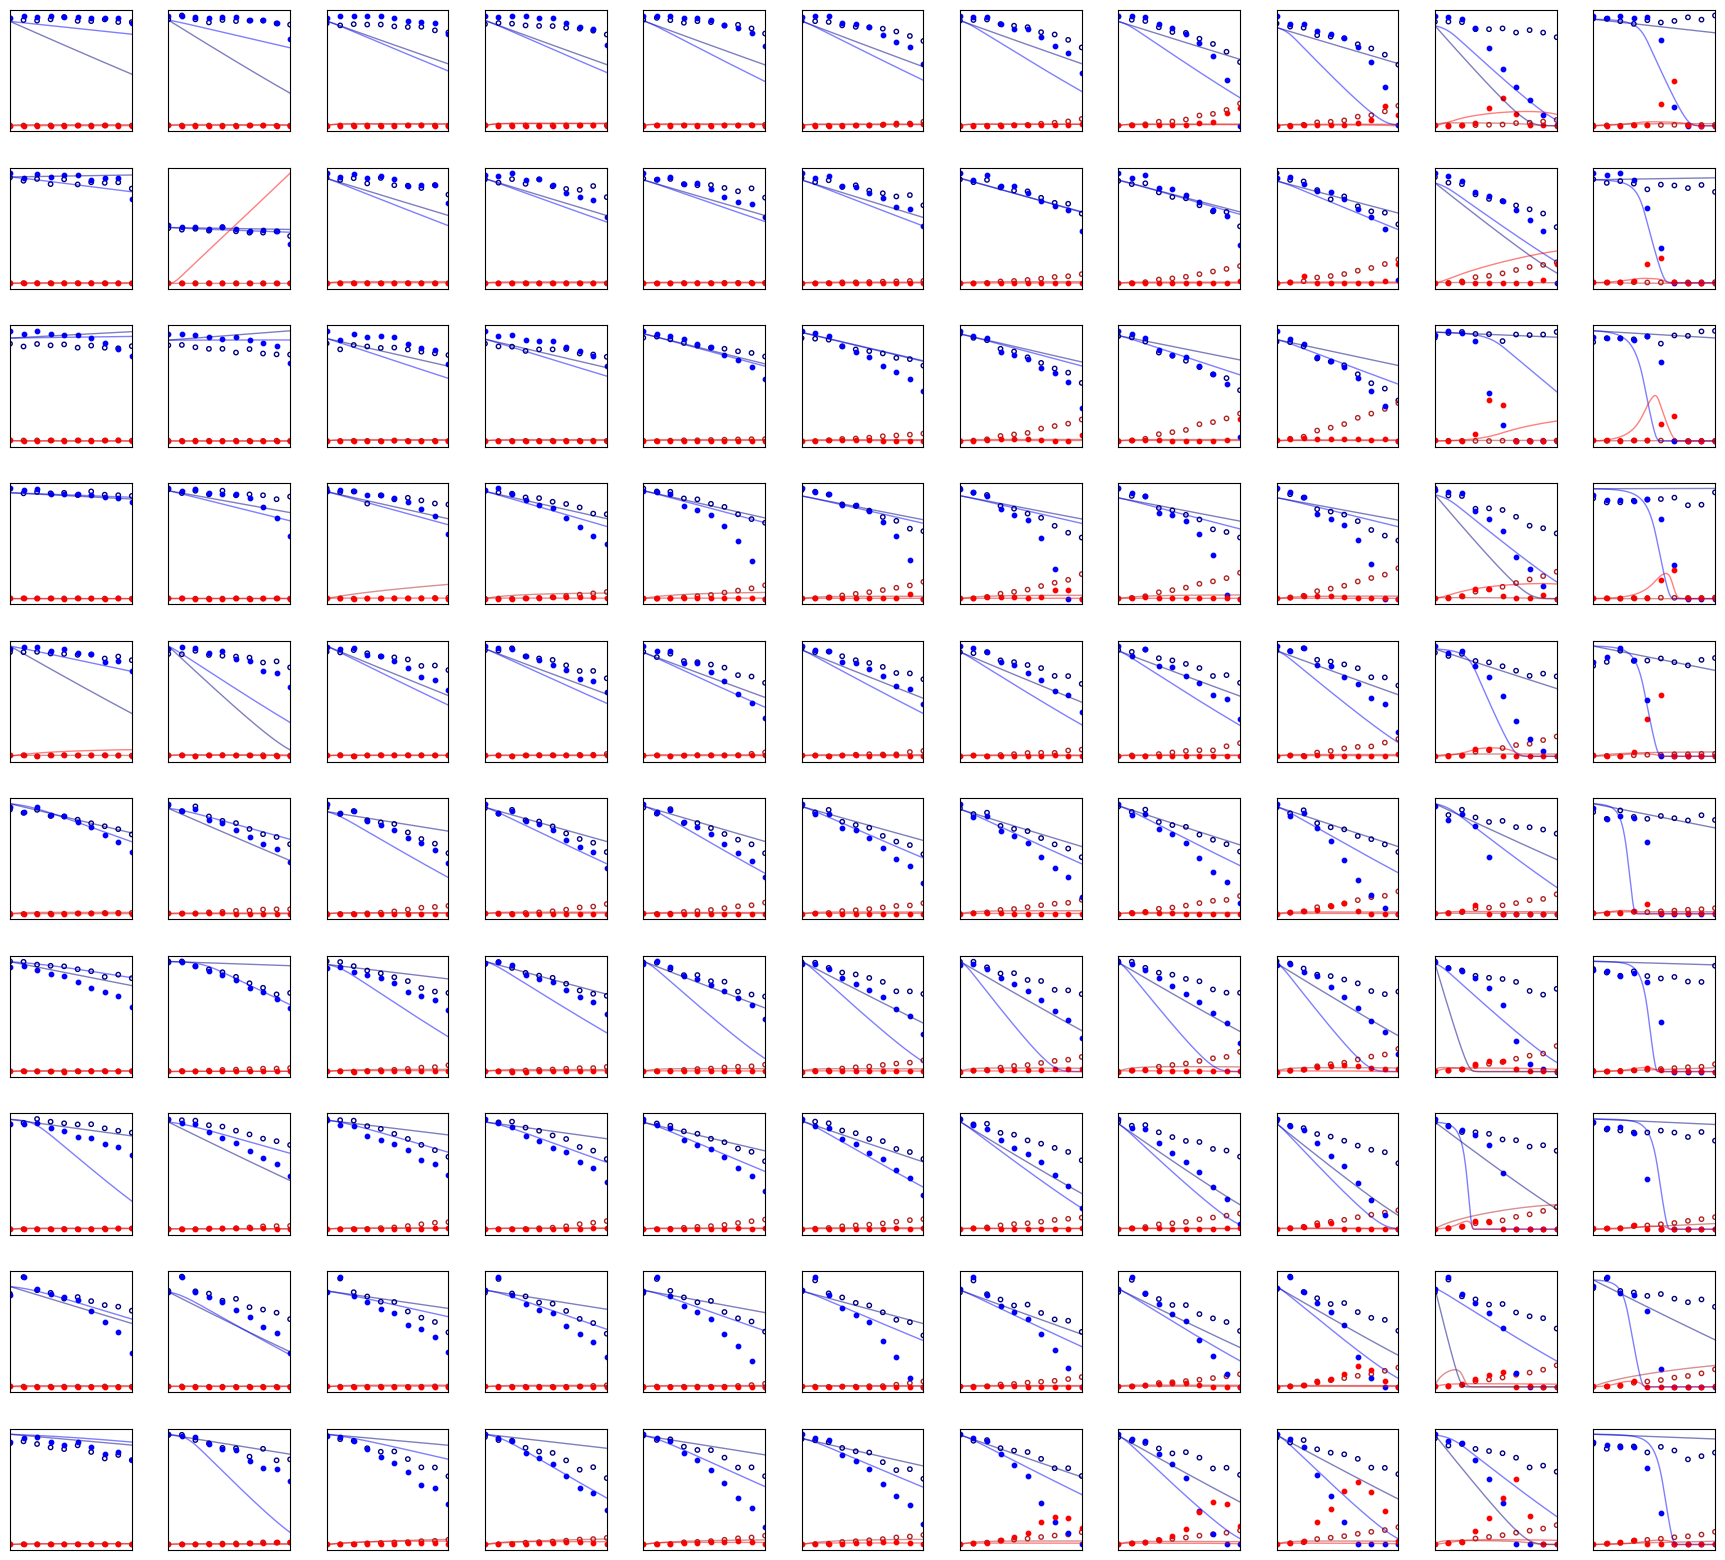

In [77]:



fig, axs = plt.subplots(10, 11, figsize=(22, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


t_data = np.linspace(0, 19, 20)
soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 
         'Soil15', 'Soil16', 'Soil17']

A_0 = 2
I_0 = 0
K_A = 0.1
K_I = 0.1
K_C = 0.1
dt = 0.05
T = 9
gamma = 5

c0 = pd.read_csv('../out/metabolic_parameters/inferred_c0.tsv', sep = '\t', header=None).values
x0 = pd.read_csv('../out/metabolic_parameters/inferred_x0.tsv', sep = '\t', header=None).values

N = int(T/dt)


for native in tqdm.trange(10, desc = 'native'): 
    for pert in tqdm.trange(11, desc = 'perturbed'):  
        
        x_0 = x0[native, pert]
        C_0 = c0[native, pert]

        sample = samples_from_soils(soils[9 - native])[pert]
        
        function = get_function(sample, drug = 'CHL')
        A_data_drug = np.zeros(10)
        I_data_drug = np.zeros(10)
        for i in range(3):
            A_data_drug += function[i]
            I_data_drug += function[i + 3]
        A_data_drug = A_data_drug/3
        I_data_drug = I_data_drug/3
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        function = get_function(sample)
        A_data = np.zeros(10)
        I_data = np.zeros(10)
        for i in range(3):
            A_data += function[i]
            I_data += function[i + 3]
        A_data = A_data/3
        I_data = I_data/3
        y_data = np.concatenate([A_data, I_data])
        
        y0 = np.array([x_0, A_0, I_0, C_0])
        params = [0, 0, nar_predictions_chl_pos[native, pert], nir_predictions_chl_pos[native, pert],  K_A, K_I, K_C]
        x, A, I, C = simulate(RHS, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='navy', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='firebrick', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data_drug, color='navy', s=10, facecolors = 'none')
        ax.scatter(t_scatter, I_data_drug, color='firebrick', s=10, facecolors = 'none')
        

        y0 = np.array([x_0, A_0, I_0, C_0])
        params = [gamma, gamma, nar_predictions_chl_neg[native, pert], nir_predictions_chl_neg[native, pert], K_A, K_I, K_C]
        x, A, I, C = simulate(RHS, y0, params, dt, T)

        t = np.linspace(0, 9, N)
        t_scatter = np.linspace(0, 9, 10)
        
        ax = axs[native, pert]
        ax.plot(t, A, color='Blue', alpha=0.5, linewidth=1)
        ax.plot(t, I, color='Red', alpha=0.5, linewidth=1)
        ax.scatter(t_scatter, A_data, color='Blue', s=10)
        ax.scatter(t_scatter, I_data, color='Red', s=10)
        
        ax.set_xlim(0, 9)
        
        ax.set_xticks([])
        ax.set_yticks([])
        

plt.show()